In [4]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings;
warnings.simplefilter('ignore')
%matplotlib inline


In [5]:
train_images  = pd.read_csv("dataset/train/images.csv",header=None)
train_labels  = pd.read_csv("dataset/train/labels.csv",header=None)

In [6]:
val_images  = pd.read_csv("dataset/validation/images.csv",header=None)
val_labels  = pd.read_csv("dataset/validation/labels.csv",header=None)

In [7]:
train_images.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,8132,8133,8134,8135,8136,8137,8138,8139,8140,8141,8142,8143,8144,8145,8146,8147,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,0.729412,0.725490,0.619608,0.674510,0.643137,0.705882,0.713726,0.658824,0.615686,0.690196,0.654902,0.525490,0.556863,0.541176,0.482353,0.588235,0.615686,0.600000,0.603922,0.627451,0.678431,0.658824,0.698039,0.576471,0.678431,0.686275,0.690196,0.705882,0.705882,0.643137,0.717647,0.705882,0.690196,0.694118,0.639216,0.635294,0.643137,0.670588,0.654902,0.635294,0.666667,0.713726,0.741176,0.650980,0.654902,0.631373,0.627451,0.603922,0.666667,0.623529,...,0.674510,0.635294,0.643137,0.654902,0.682353,0.639216,0.647059,0.639216,0.658824,0.666667,0.666667,0.678431,0.650980,0.619608,0.650980,0.647059,0.592157,0.650980,0.615686,0.666667,0.650980,0.666667,0.666667,0.709804,0.682353,0.682353,0.682353,0.658824,0.682353,0.643137,0.627451,0.623529,0.650980,0.721569,0.627451,0.635294,0.709804,0.690196,0.678431,0.647059,0.658824,0.682353,0.654902,0.694118,0.741176,0.678431,0.662745,0.729412,0.694118,0.647059,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,0.678431,0.709804,0.713726,0.686275,0.717647,0.713726,0.694118,0.690196,0.721569,0.701961,0.698039,0.713726,0.705882,0.756863,0.756863,0.694118,0.650980,0.674510,0.752941,0.725490,0.725490,0.760784,0.678431,0.717647,0.725490,0.682353,0.709804,0.729412,0.721569,0.717647,0.698039,0.666667,0.717647,0.752941,0.678431,0.686275,0.749020,0.698039,0.745098,0.733333,0.752941,0.721569,0.717647,0.682353,0.709804,0.745098,0.690196,0.705882,0.737255,0.713726,...,0.705882,0.745098,0.713726,0.694118,0.713726,0.717647,0.717647,0.678431,0.670588,0.466667,0.611765,0.756863,0.717647,0.737255,0.752941,0.698039,0.717647,0.698039,0.717647,0.690196,0.686275,0.670588,0.713726,0.733333,0.725490,0.694118,0.694118,0.686275,0.674510,0.729412,0.721569,0.701961,0.682353,0.709804,0.756863,0.698039,0.729412,0.721569,0.674510,0.698039,0.725490,0.733333,0.666667,0.682353,0.701961,0.737255,0.745098,0.725490,0.698039,0.650980,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,0.690196,0.670588,0.662745,0.666667,0.713726,0.701961,0.721569,0.713726,0.662745,0.698039,0.682353,0.639216,0.717647,0.658824,0.674510,0.639216,0.643137,0.635294,0.654902,0.682353,0.639216,0.733333,0.690196,0.658824,0.686275,0.658824,0.690196,0.698039,0.709804,0.650980,0.670588,0.721569,0.694118,0.662745,0.701961,0.678431,0.623529,0.705882,0.749020,0.698039,0.694118,0.705882,0.682353,0.705882,0.717647,0.694118,0.690196,0.686275,0.682353,0.698039,...,0.650980,0.662745,0.694118,0.729412,0.705882,0.733333,0.709804,0.654902,0.690196,0.678431,0.705882,0.705882,0.670588,0.690196,0.713726,0.698039,0.690196,0.698039,0.552941,0.568627,0.533333,0.572549,0.537255,0.549020,0.670588,0.690196,0.670588,0.643137,0.662745,0.713726,0.717647,0.721569,0.709804,0.674510,0.709804,0.686275,0.658824,0.694118,0.698039,0.694118,0.678431,0.678431,0.690196,0.662745,0.650980,0.650980,0.686275,0.631373,0.666667,0.701961,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,0.631373,0.650980,0.670588,0.737255,0.674510,0.615686,0.670588,0.705882,0.686275,0.678431,0.694118,0.647059,0.662745,0.682353,0.654902,0.721569,0.709804,0.631373,0.670588,0.67

In [8]:
train_labels.head(4)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0


In [9]:
print("Training set shape :" , train_images.shape ,train_labels.shape)
print("Validation set shape :" , val_images.shape ,val_labels.shape)

Training set shape : (3200, 8192) (3200, 4)
Validation set shape : (800, 8192) (800, 4)


In [11]:
x_train  =  train_images.values.reshape(3200 ,64,128,1)
x_val  =  val_images.values.reshape(800 ,64,128,1)

y_train = train_labels.values
y_val = val_labels.values

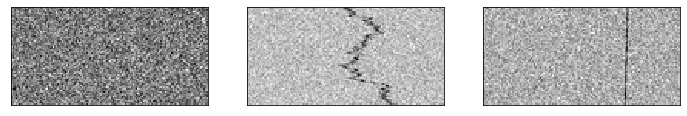

In [15]:
plt.figure(0 ,  figsize =(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img,cmap='gray')

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_train)

In [24]:
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten , Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model ,Sequential
from tensorflow.keras.optimizers import Adam ,SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
#Initialising the CNN 
model =  Sequential()
#1st  Convolution 
model.add(Conv2D(32,(5,5),padding="same" , input_shape = (64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size =(2,2)))
model.add(Dropout(0.25))

#2nd Convolution layer
model.add(Conv2D(64,(5,5),padding="same" ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size =(2,2)))
model.add(Dropout(0.25))

#Flattening
model.add(Flatten())
#Fully Conected layer

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4,activation='softmax'))


In [34]:
initial_learning_rate = 0.005
lr_schedule =  tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

In [35]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy",metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 64, 64)       

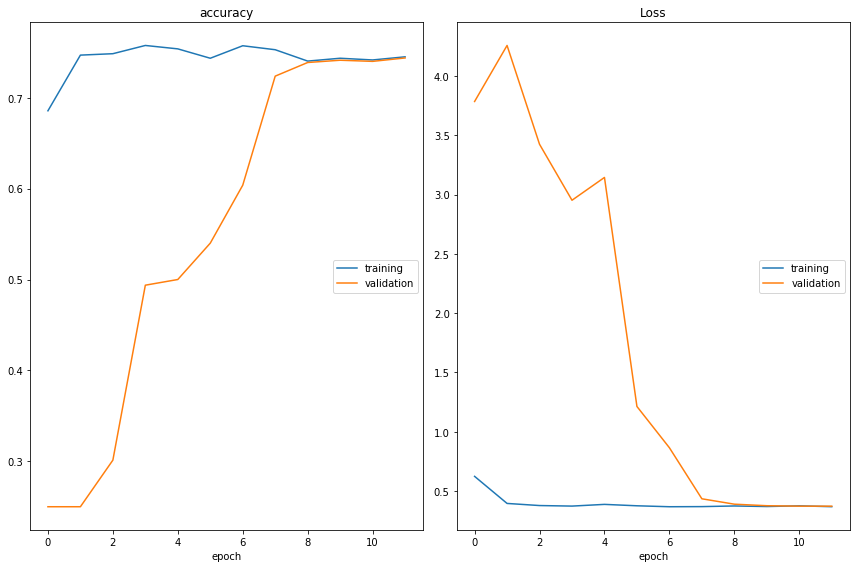

accuracy
	training         	 (min:    0.686, max:    0.757, cur:    0.745)
	validation       	 (min:    0.250, max:    0.744, cur:    0.744)
Loss
	training         	 (min:    0.368, max:    0.624, cur:    0.368)
	validation       	 (min:    0.373, max:    4.257, cur:    0.373)
100/100 [==============================] - 97s 974ms/step - loss: 0.3685 - accuracy: 0.7450 - val_loss: 0.3728 - val_accuracy: 0.7437


In [49]:
from livelossplot import PlotLossesKeras
checkpoint = ModelCheckpoint("model_weights.h5" , monitor ="val_loss", save_weights_only = True , 
                             mode ='min',verbose =0)
callbacks = [PlotLossesKeras(), checkpoint]
batch_size = 32

history =model.fit(
  datagen_train.flow(x_train,y_train,batch_size=batch_size,shuffle=True),
  steps_per_epoch = len(x_train)//batch_size,
  validation_data = datagen_val.flow(x_val,y_val,batch_size=batch_size,shuffle=True),
  validation_steps = len(x_val)//batch_size,
  epochs =12,
  callbacks=callbacks)

In [47]:
tf.__version__

'2.3.0'

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns


In [51]:
model.evaluate(x_val,y_val)

25/25 [==============================] - 2s 83ms/step - loss: 0.3731 - accuracy: 0.7387


[0.3731085956096649, 0.7387499809265137]

In [53]:
y_true = np.argmax(y_val,1)
y_pred = np.argmax(model.predict(x_val),1)
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       200
           1       0.49      0.98      0.65       200
           2       0.00      0.00      0.00       200
           3       1.00      1.00      1.00       200

    accuracy                           0.74       800
   macro avg       0.62      0.74      0.66       800
weighted avg       0.62      0.74      0.66       800



In [56]:
print("Clf Accuracy :",metrics.accuracy_score(y_true,y_pred))

Clf Accuracy : 0.73875


In [57]:
labels = ['squiggle','narrowband','noise','narrowbanddrd']